# Notebook API Python Spark GraphFrames-2026


**GraphFrames**
*   https://graphframes.io/table-of-content.html


**GraphFrames Python API**
*   https://graphframes.io/api/python/




***Install pyspark and findspark:***

In [ ]:
!pip uninstall dataproc-spark-connect -y

Found existing installation: dataproc-spark-connect 1.0.1
Uninstalling dataproc-spark-connect-1.0.1:
  Successfully uninstalled dataproc-spark-connect-1.0.1


In [ ]:
!pip install pyspark==3.5.1
!pip install -q findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 15.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=41c0d67dad09b95367c1f729afeea657b173a3ceed162e73308f9c3b766e2ef3
  Stored in directory: /root/.cache/pip/wheels/b1/91/5f/283b53010a8016a4ff1c4a1edd99bbe73afacb099645b5471b
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.9
    Uninstalling py4j-0.10.9.9:
      Successfully uninstalled py4j-0.10.9.9
  Attempting uninstall: pyspark
    Found existing installation: pyspark 4.0.1
    Uninstalling pyspark-4.0.1:
      Successfully uninstalled pyspark-4.0.1


***Install GraphFrames :***

In [ ]:
!pip install -q graphframes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.2 MB/s eta 0:00:00


In [ ]:
!curl -L -o "/usr/local/lib/python3.12/dist-packages/pyspark/jars/graphframes-0.8.3-spark3.5-s_2.12.jar" http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.3-spark3.5-s_2.12/graphframes-0.8.3-spark3.5-s_2.12.jar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   164  100   164    0     0    799      0 --:--:-- --:--:-- --:--:--   803
100   146  100   146    0     0    232      0 --:--:-- --:--:-- --:--:--  1158


***Start the spark session:***

In [ ]:
import os
# !find /usr/local -name "pyspark"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.12/dist-packages/pyspark"
os.environ["JAVA_HOME"] = "/usr"

In [ ]:
# Main imports
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkConf

# for dataframe and udf
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

import pandas as pd


# initialise environment variables for spark
findspark.init()

# Start spark session
# --------------------------
def start_spark():
  local = "local[*]"
  appName = "TP"

  gf = "graphframes:graphframes:0.8.3-spark3.5-s_2.12"

  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory").\
  set("spark.jars.packages", gf)

  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")

  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # Adjust the query execution environment to the size of the cluster (4 cores)
  spark.conf.set("spark.sql.shuffle.partitions","4")
  print("session started, its id is ", sc.applicationId)
  return spark
spark = start_spark()

session started, its id is  local-1768309829314


In [ ]:
#Import GraphFrames
from graphframes import GraphFrame
from graphframes.lib import AggregateMessages as AM
from graphframes.lib import Pregel

#For connectedComponents()
!pwd
!mkdir /content/checkpoints
spark.sparkContext.setCheckpointDir('/content/checkpoints')

#Import networkx
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

/content


In [ ]:
# alternatives to Databricks display function.
from google.colab import data_table

def display(df, n=100):
  return data_table.DataTable(df.limit(n).toPandas(), include_index=False, num_rows_per_page=10)

def display2(df, n=20):
  pd.set_option('max_columns', None)
  pd.set_option('max_colwidth', None)
  return df.limit(n).toPandas()

In [ ]:
def plot_directed_graph(gf):

  gplot = nx.DiGraph()
  edge_labels = {}

  plt.figure(figsize=(6, 7))
  for node in gf.vertices.select('id').take(1000):
    gplot.add_node(node['id'])

  for row in gf.edges.select('src', 'dst', 'relationship').take(1000):
    gplot.add_edge(row['src'], row['dst'])
    edge_labels[(row['src'], row['dst'])] = row['relationship']

  pos = nx.shell_layout(gplot)

  nx.draw(gplot,
          pos,
          with_labels=True,
          font_weight='bold',
          node_size=1800,
          font_size=15,
          node_color='orange',
          width=2)

  nx.draw_networkx_edge_labels(gplot,
                               pos,
                               edge_labels=edge_labels,
                               font_color='red',
                               font_size=10,
                               font_weight='bold')

In [ ]:
def plot_bar(df, x_limit, xcolname,  ycolname, rotation=True):

    plt.style.use('fivethirtyeight')
    ax = (df
      .toPandas()
      .head(x_limit)
      .plot(kind='bar', x=xcolname, y=ycolname, legend=None))
    ax.xaxis.set_label_text("")
    if rotation:
      plt.xticks(rotation=45)
    plt.tight_layout()

**Working on a small example graph**

In [ ]:
# Vertex DataFrame
v = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 36),
  ("g", "Gabby", 60)
], ["id", "name", "age"])


In [ ]:
# Edge DataFrame
e = spark.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
  ("e", "d", "friend"),
  ("d", "a", "friend"),
  ("a", "e", "friend")
], ["src", "dst", "relationship"])

In [ ]:
# Create a GraphFrame
g=GraphFrame(v, e)

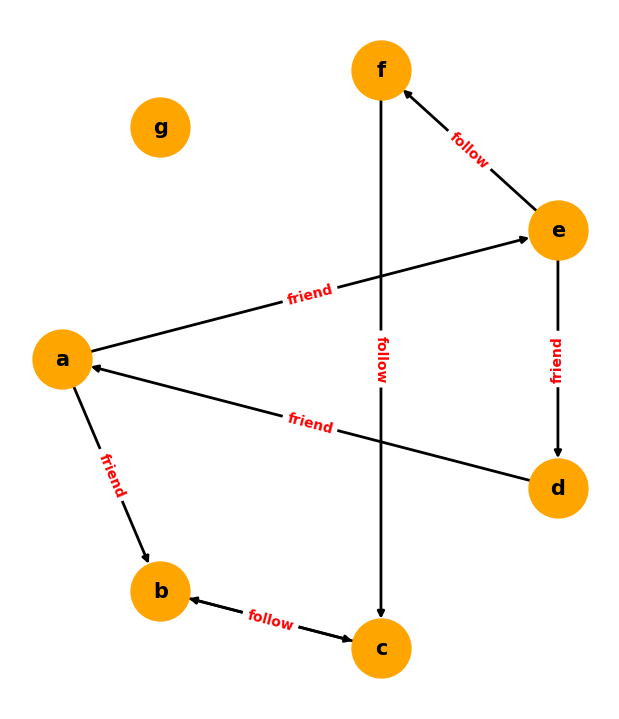

In [ ]:
plot_directed_graph(g)

**dropIsolatedVertices**

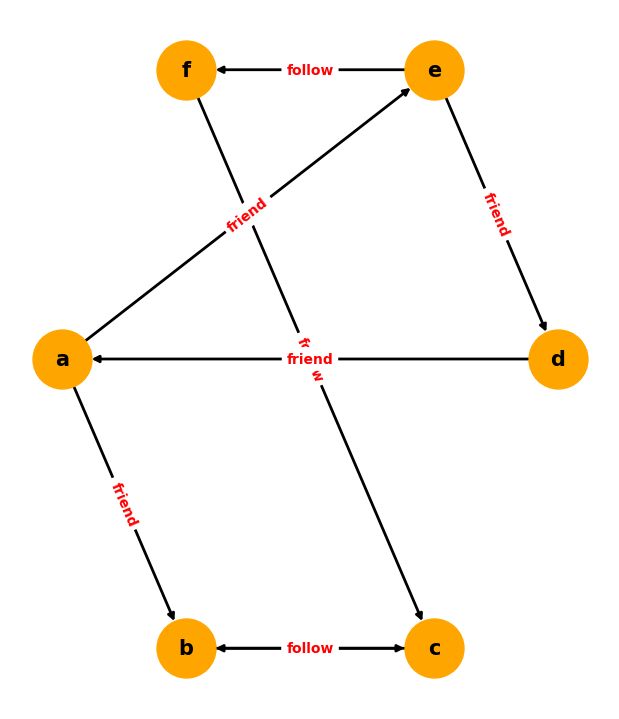

In [ ]:
g=g.dropIsolatedVertices()
plot_directed_graph(g)

**Views**

In [ ]:
g.vertices.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- age: long (nullable = true)



In [ ]:
g.vertices.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
+---+-------+---+



In [ ]:
g.edges.printSchema()

root
 |-- src: string (nullable = true)
 |-- dst: string (nullable = true)
 |-- relationship: string (nullable = true)



In [ ]:
g.edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+



In [ ]:
g.triplets.printSchema()

root
 |-- src: struct (nullable = false)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- age: long (nullable = true)
 |-- edge: struct (nullable = false)
 |    |-- src: string (nullable = true)
 |    |-- dst: string (nullable = true)
 |    |-- relationship: string (nullable = true)
 |-- dst: struct (nullable = false)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- age: long (nullable = true)



In [ ]:
g.triplets.show()

+----------------+--------------+----------------+
|             src|          edge|             dst|
+----------------+--------------+----------------+
|  {d, David, 29}|{d, a, friend}|  {a, Alice, 34}|
|  {a, Alice, 34}|{a, b, friend}|    {b, Bob, 36}|
|{c, Charlie, 30}|{c, b, follow}|    {b, Bob, 36}|
|    {b, Bob, 36}|{b, c, follow}|{c, Charlie, 30}|
|  {f, Fanny, 36}|{f, c, follow}|{c, Charlie, 30}|
| {e, Esther, 32}|{e, d, friend}|  {d, David, 29}|
|  {a, Alice, 34}|{a, e, friend}| {e, Esther, 32}|
| {e, Esther, 32}|{e, f, follow}|  {f, Fanny, 36}|
+----------------+--------------+----------------+



**Basic graph and DataFrame queries**

In [ ]:
# Get a DataFrame with columns "id" and "inDegree" (in-degree)
vertexInDegrees = g.inDegrees
vertexInDegrees.show()

+---+--------+
| id|inDegree|
+---+--------+
|  b|       2|
|  c|       2|
|  f|       1|
|  d|       1|
|  a|       1|
|  e|       1|
+---+--------+



**Motif finding**

In [ ]:
# Search for pairs of vertices with edges in both directions between them.
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.show()

+----------------+--------------+----------------+--------------+
|               a|             e|               b|            e2|
+----------------+--------------+----------------+--------------+
|{c, Charlie, 30}|{c, b, follow}|    {b, Bob, 36}|{b, c, follow}|
|    {b, Bob, 36}|{b, c, follow}|{c, Charlie, 30}|{c, b, follow}|
+----------------+--------------+----------------+--------------+



In [ ]:
#Friends of friends
fof = g.find("(x)-[]->(y); (y)-[]->(z); !(x)-[]->(z)").filter("x.id != z.id")
fof.select(col('x.id').alias('x'), col('y.id').alias('y'), col('z.id').alias('z')).show()

+---+---+---+
|  x|  y|  z|
+---+---+---+
|  a|  e|  d|
|  d|  a|  b|
|  d|  a|  e|
|  a|  b|  c|
|  e|  d|  a|
|  f|  c|  b|
|  e|  f|  c|
|  a|  e|  f|
+---+---+---+



**Subgraphs**

In [ ]:
# First application

# Select subgraph of users older than 30, and relationships of type "friend".
# Drop isolated vertices (users) which are not contained in any edges (relationships).
g1 = g.filterVertices("age > 30").filterEdges("relationship = 'friend'").dropIsolatedVertices()

In [ ]:
g.vertices.filter("age > 30").show()

+---+------+---+
| id|  name|age|
+---+------+---+
|  a| Alice| 34|
|  b|   Bob| 36|
|  e|Esther| 32|
|  f| Fanny| 36|
+---+------+---+



In [ ]:
g.edges.filter("relationship = 'friend'").show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+



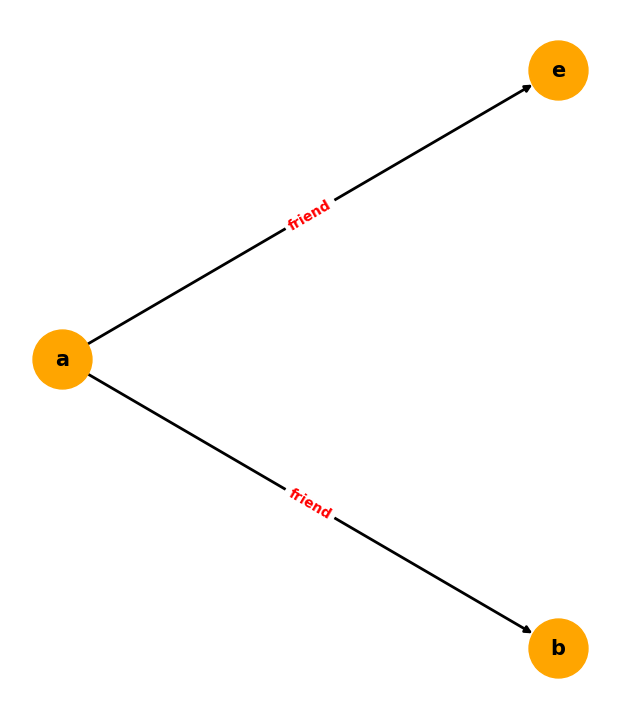

In [ ]:
plot_directed_graph(g1)

In [ ]:
# Second Application

# Select subgraph based on edges "e" of type "follow"
# pointing from a younger user "a" to an older user "b".
paths = g.find("(a)-[e]->(b)")\
  .filter("e.relationship = 'follow'")\
  .filter("a.age < b.age")
# "paths" contains vertex info. Extract the edges.
e2 = paths.select("e.src", "e.dst", "e.relationship")

In [ ]:
g.triplets.filter("src.age < dst.age").show()

In [ ]:
e2.show()

In [ ]:
# Construct the subgraph
g2 = GraphFrame(g.vertices, e2)
plot_directed_graph(g2)

****Graph algorithms****

**BFS**

In [ ]:
# Search from "Esther" for users of age < 32.
g.bfs("name = 'Esther'", "age < 32",\
  edgeFilter="relationship != 'friend'", maxPathLength=3).show()

**Connected components**

In [ ]:
g.connectedComponents().orderBy("component").show()

**Strongly connected components**

In [ ]:
g.stronglyConnectedComponents(maxIter=10).orderBy("component").show()

**LPA**

In [ ]:
g.labelPropagation(maxIter=3).show()

**Page Rank**

In [ ]:
# Run PageRank until convergence to tolerance "tol".
results = g.pageRank(resetProbability=0.15, tol=0.01)

In [ ]:
results.vertices.select("id", "pagerank").show()
results.edges.select("src", "dst", "weight").show()

**Shortest paths**

In [ ]:
g.shortestPaths(landmarks=["a", "d"]).select("id", "distances").printSchema()

**Triangle count**

In [ ]:
g.triangleCount().select("id", "count").show()

**aggregateMessages**

In [ ]:
g.vertices.show()

In [ ]:
from pyspark.sql.functions import sum
from graphframes.lib import AggregateMessages as AM

# For each user, sum the ages of the adjacent users.
msgToSrc = AM.dst["age"]
msgToDst = AM.src["age"]
agg = g.aggregateMessages(
    sum(AM.msg).alias("summedAges"),
    sendToSrc=msgToSrc,
    sendToDst=msgToDst)
agg.show()

**PageRank with Pregel**

**Add the outDegrees**

In [ ]:
vertices2 = g.vertices.join(g.outDegrees,g.vertices.id == g.outDegrees.id).drop(g.outDegrees.id)
g2 = GraphFrame(vertices2, e)
#display(vertices2)
vertices2.show()

In [ ]:
alpha = 0.15
numVertices = g2.vertices.count()
ranks = g2.pregel \
     .setMaxIter(1) \
    .withVertexColumn("rank", lit(1.0 / numVertices), \
         round(coalesce(Pregel.msg(), lit(0.0)) * lit(1.0 - alpha) + lit(alpha / numVertices), 2)) \
     .sendMsgToDst(Pregel.src("rank") / Pregel.src("outDegree")) \
     .aggMsgs(sum(Pregel.msg())) \
     .run()

ranks.show()

In [ ]:
#Initialisation
ranks_0 = g2.vertices.withColumn("rank", round(lit(1.0/numVertices), 2))
ranks_0.show()